In [1]:
#skip warnings for this demo
import warnings
warnings.filterwarnings('ignore')

#load libraries
from PIL import Image,ImageDraw
import requests
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms as T

### Loading package

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

DATA_PATH = os.getenv('DATA_PATH')
MODEL_PATH = os.getenv('MODEL_PATH')
DATA_PATH, MODEL_PATH

('/media/felipe/DATA19/datasets/', '/media/felipe/DATA19/models/')

# GPU Availability

In [3]:
#GPU configuration
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

cuda:0


# Definition of Graffiti Detection model
This includes model weights loading, too. 

In [4]:
#Image transformer
transform = T.Compose([
    T.Resize((640,480)),
    T.ToTensor()])

#faster rcnn model definiation
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_channels = in_features, num_classes=2)
model.to(device = device)

#set it in evaluation mode
model.eval()

#load weights
model.load_state_dict(torch.load(f'{MODEL_PATH}/17kgraffiti/fasterrcnn_resnet50_fpn.pth'))

<All keys matched successfully>

# Graffiti detection on an example image

In [5]:
#let's get an unseen example of graffiti image with multi graffiti instances from an url
# the image copyright blongs to www.images.unsplash.com
image_url = 'https://images.unsplash.com/photo-1530406831759-15c5c0cbce8b?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=627&q=80'

In [6]:
#get and read image from url
image = Image.open(requests.get(image_url,stream=True).raw)

#transferring image into tensor and resize
image_transferred = transform(image).float().unsqueeze(0)

#model prediction
pred = model(image_transferred.to(device))

In [7]:
#this function helps to draw detected bounding boxes on the image
def draw_bounding_box_with_scores(tensor,bboxes, scores, width=4, thresh = 0.8):
    ndarr = tensor.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()
    im = Image.fromarray(ndarr)
    draw = ImageDraw.Draw(im)
    
    for bbox,src in zip(bboxes,scores):
        if src < thresh:continue
        draw.rectangle(bbox, width=width, outline='red')
        
    from numpy import array as to_numpy_array
    return torch.from_numpy(to_numpy_array(im))

In [8]:
#list of desired confidences 
detection_confidence = [0.10, 0.50, 0.80]

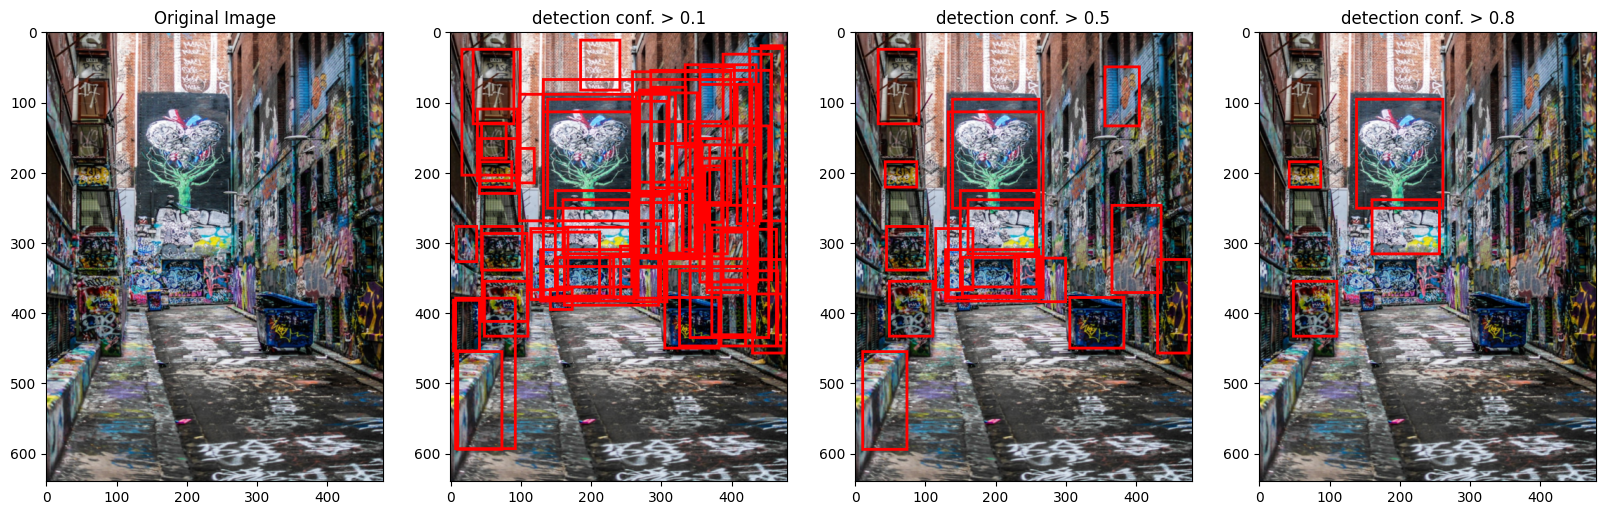

In [9]:
#plot boundary boxes of image upon to the given confidence
fig,ax = plt.subplots(1,len(detection_confidence)+1,figsize=(20,10))
ax[0].imshow(image_transferred[0].permute(1, 2, 0))
ax[0].set_title('Original Image')

for i, conf in enumerate(detection_confidence):
    res_img = draw_bounding_box_with_scores(image_transferred[0], 
                                    pred[0]['boxes'].cpu().detach().numpy(),
                                    pred[0]['scores'].cpu().detach().numpy(),
                                    thresh=conf)
    
    ax[i+1].imshow(res_img)
    ax[i+1].set_title(f'detection conf. > {conf}')
